# Dark Field Segmentation

load extensions

In [1]:
# Calibration

%load_ext autoreload
%autoreload 2

%matplotlib notebook
import numpy as np
import hyperspy.api as hs
import pyxem as pxm
import matplotlib.pyplot as plt
import os
import sys

from pyxem.libraries.calibration_library import CalibrationDataLibrary
from pyxem.generators.calibration_generator import CalibrationGenerator

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

import math

import warnings
warnings.simplefilter(action='ignore')
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

import sys
sys.path.append('/dls/science/groups/e02/Mohsen/code/Git_Repos/Merlin-Medipix/')
import epsic_tools.api as epsic

/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


## Load Dataset

In [2]:
d = hs.load('/dls/e02/data/2021/mg28749-1/processing/Calibrated_MD/20210925_152115/20210925_152115_data.hdf5')

<IPython.core.display.Javascript object>


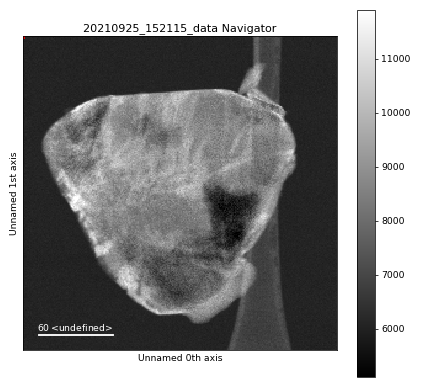

<IPython.core.display.Javascript object>


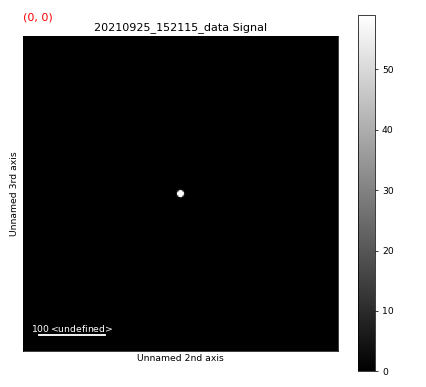

In [3]:
d.plot()

## Use py4Dstem to find all the peaks

<IPython.core.display.Javascript object>


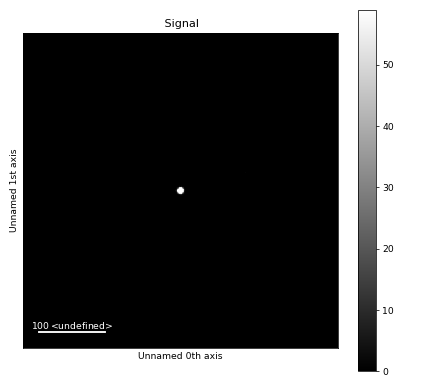

In [4]:
cent_beam = d.inav[10,10]
cent_beam.plot()

In [5]:
d_sum = d.max()

<IPython.core.display.Javascript object>


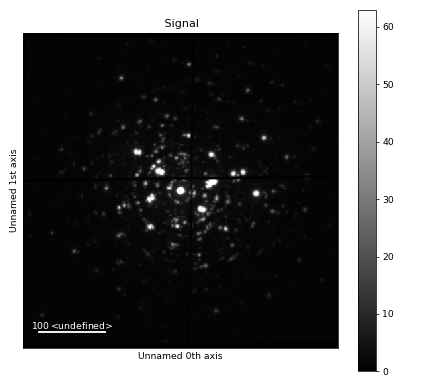

In [6]:
d_sum.plot()

In [7]:
cent_beam_int = cent_beam.data * np.max(d_sum.data) / np.max(cent_beam.data)

In [8]:
from scipy.ndimage import gaussian_filter

In [9]:
def remove_central_beam(pattern, beam_template, sigma):
    
#     beam_blurred = gaussian_filter(beam_template, sigma=5)
    cent_beam_int = beam_template * np.max(pattern) / np.max(beam_template)
    beam_blurred = gaussian_filter(cent_beam_int, sigma=5)
    return pattern - beam_blurred

def mask_central_beam(pattern, radius):
    shape = pattern.shape
    z = np.ones((shape[0],shape[1]))
    ci,cj=shape[0]//2,shape[1]//2
    I,J=np.meshgrid(np.arange(z.shape[0]),np.arange(z.shape[1]))
    dist=np.sqrt((I-ci)**2+(J-cj)**2)
    z[np.where(dist<radius)]=0
    
    masked_pattern = pattern * z
    return masked_pattern

In [10]:
test = mask_central_beam(d_sum.data, 20)

<IPython.core.display.Javascript object>


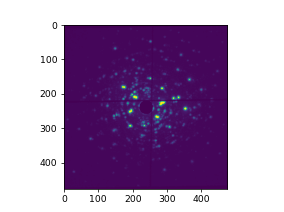

In [14]:
plt.figure()
plt.imshow(test)

In [11]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


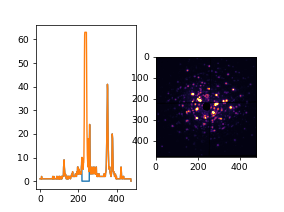

In [15]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(test[476//2, :])
plt.plot(d_sum.data[476//2, :])
plt.subplot(1,2,2)
plt.imshow(test, cmap = 'inferno', vmax = 30)

<IPython.core.display.Javascript object>


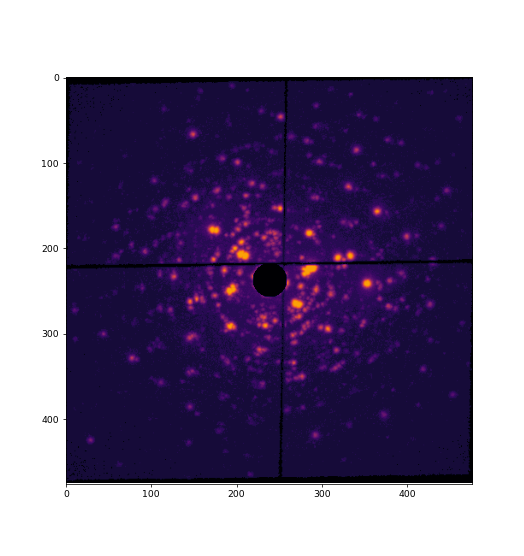

In [17]:
plt.figure()
plt.imshow(np.sqrt(test), vmax = 10, cmap = 'inferno')

In [18]:
# A^-1 per pixel
diff_cal = 0.00965 

In [19]:
d.set_diffraction_calibration(diff_cal)

In [20]:
d_masked = pxm.signals.ElectronDiffraction2D(np.sqrt(test))
d_masked.set_diffraction_calibration(diff_cal)

<IPython.core.display.Javascript object>


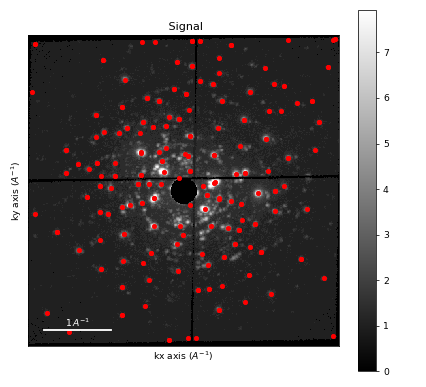

In [22]:
# Peak find over the sum signal and get the peaks positions
sigma_min = 1.2
sigma_max = 20
# peaks = d_masked.find_peaks(method='difference_of_gaussian', min_sigma = sigma_min, max_sigma = sigma_max, ineractive=True)
peaks = d_masked.find_peaks(method='stat', ineractive=True)

In [23]:
peaks = d_masked.find_peaks(method='stat', alpha = 0.5, ineractive=False)

In [24]:
peaks_cal = (peaks.data * diff_cal) - (476 // 2) * 0.00965
# + d.axes_manager[0].offset

<IPython.core.display.Javascript object>


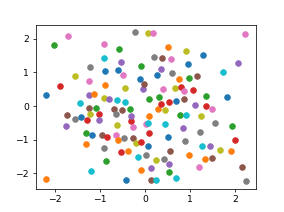

In [25]:
import matplotlib.pyplot as plt
plt.figure()
for i in range(peaks.data.shape[0]):
    plt.scatter(peaks_cal[i][1], peaks_cal[i][0])

In [26]:
ap = hs.roi.CircleROI(cx=peaks_cal[0][1], cy=peaks_cal[0][0], r=0.10, r_inner=0)

In [27]:
d_ = pxm.signals.electron_diffraction2d.ElectronDiffraction2D(d)

In [28]:
d_.set_diffraction_calibration(diff_cal)

In [29]:
import os
import matplotlib.pyplot as plt
def save_DF_images(d, peaks, rad, path):
    os.chdir(path)
    for i in range(len(peaks)):
        ap = hs.roi.CircleROI(cx=peaks[i][1], cy=peaks[i][0], r=rad, r_inner=0)
        df1 = d.get_integrated_intensity(ap)
#         df1.save(f'DF_image_ap_pos_x{peaks[i][1]}_pos_y{peaks[i][0]}_rad_{rad}')
        df1.save(f'DF_image_ap_pos_x{peaks[i][1]}_pos_y{peaks[i][0]}_rad_{rad}.png')
#         plt.figure()
#         plt.imshow()

save_DF_images(d_, peaks_cal, rad = 0.1, path = '/dls/science/groups/e02/Mohsen/BillDavid_data/DF_test')

In [30]:
for i in range(len(peaks_cal)):
    ap = hs.roi.CircleROI(cx=peaks_cal[i][1], cy=peaks_cal[i][0], r=0.10, r_inner=0)
    
    if i == 0:
        all_df = np.asarray(d_.get_integrated_intensity(ap).data)[None, :,:]
    else:

        t_df_reg = np.asarray(d_.get_integrated_intensity(ap).data)[None, :,:]
        all_df = np.concatenate([all_df, t_df_reg], axis = 0)

## Now Use Graphs to determine similarity

#### Define some functions

In [31]:
from skimage.metrics import normalized_root_mse as nrmse
import networkx as nx
import itertools



def get_distance_matrix(all_df, dm, process_df):
    '''
    all_df: The dark field navigation images you want to compare
    dm: The distance metric you want to use for comparison
    process_df: any image processing function you want to pre apply to the dark fields'''
    tbdf = process_df(all_df)
    mses = np.zeros((len(tbdf),len(tbdf)))
    for i in range(len(tbdf)):
        for j in range(len(tbdf)):
            mses[i,j] = dm(tbdf[i], tbdf[j])
    return mses

def get_graph_from_connectivity(uthresh):
    '''
    uthresh: the connectivity matrix from which the graph can be generated
    '''
    g = nx.Graph()
    inds_in_graph = np.unique(uthresh)
    g.add_nodes_from(inds_in_graph)
    g.add_edges_from(uthresh)
    return g, inds_in_graph

def get_new_dfs(all_df, con_comps, inds_in_graph, info = True):
    '''
    all_df: All the dark field images compared
    con_comps: The connected components from the graph analysis
    inds_in_graph: The dark field indices that have been used
    info: Whether or not to return information about which patterns have been combined
    '''
    
    ndf = [all_df[x] for x in range(len(all_df)) if len(np.where(inds_in_graph ==x)[0]) == 0]
    cc = [list(x) for x in con_comps]
    if info == False:
        [ndf.append(np.mean([all_df[x] for x in s],axis = 0)) for s in cc]
        return ndf
    if info == True:
        info_patts = []
        comb_ind = len(ndf)
        for s in cc:
            new_df = np.mean([all_df[x] for x in s],axis = 0)
            ndf.append(new_df)
            info_patts.append(([all_df[x] for x in s], new_df))
        return ndf, info_patts

def thresh_distances(ndistances, thresh):
    '''
    ndistances: distance matrix
    thresh: hard threshold above which connections can be ignored'''
    nmses = ndistances.copy()
    for i in range(nmses.shape[0]):
        nmses[i,i] = 10
    return np.asarray(np.where(nmses<thresh)).T

def plot_con_patts(con_patts, **kwargs):
    '''
    con_patts: The patterns which are combined'''
    n_comb = len(con_patts[0])
    f = plt.figure()
    ax = f.add_subplot(2, 1, 2)
    ax.imshow(con_patts[1], **kwargs)
    for i in range(n_comb):
        ax = f.add_subplot(2, n_comb, i+1)
        ax.imshow(con_patts[0][i], **kwargs)
    [[a.set_xticks([]),a.set_yticks([])] for a in f.axes]
    
def view_graph(g):
    '''
    g: Graph'''
    plt.figure()
    nx.draw(g, with_labels=True)

def get_community_graph(coms):
    '''
    coms: the communities identified'''
    
    
    nodes = np.unique(np.concatenate(coms))
    
    edges = []
    isets = [list(x) for x in coms]
    for s in isets:
        if len(s) >1:
            [edges.append(x) for x in list(itertools.combinations(s,2))]
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    return g

def split_into_communities(g1, ind, ncoms):
    '''
    g1: Graph
    ind: the group of connected nodes you want to split
    ncoms: the number of communities you want to generate'''

    nodes = list(list(nx.connected_components(g1))[ind])
    
    connected_components = list(list(nx.connected_components(g1))[0:ind])
    connected_components.append(list(list(nx.connected_components(g1))[ind+1:]))
    
    if len(connected_components) == 1:
        connected_components = connected_components[0]
    con_coms = [list(x) for x in connected_components]

    cg1 = g1.subgraph(nodes)

    communes = [list(x) for x in nx.algorithms.community.asyn_fluid.asyn_fluidc(cg1, ncoms)]

    for c in communes:
        [con_coms.append(list(x)) for x in list(nx.connected_components(cg1.subgraph(c)))]
    return [x for x in con_coms if len(x) > 1]

def get_connected_nodes(g1):
    return list(nx.connected_components(g1))


def process_df(all_df):
    return [np.where(tdf<tdf.mean(), -1, 3) for tdf in all_df]

def do_nothing(all_df):
    return all_df

from skimage.filters import gaussian

def gaussian_process(all_df):
    return [gaussian(df) for df in all_df]

In [40]:
len(peaks_cal)

138

### Pass 1

Each pass follows the general approach: 
- Get distance matrix
- Prune matrix above a threshold
- Get a graph
- Split sparsely connected group into dense communities
- Generate new dark fields

Gaussian smoothing filters can be used in place of do_nothing(), for less grainy maps

In [32]:
d1 = get_distance_matrix(all_df,nrmse, do_nothing)

In [33]:
d1.mean()

14.150229714854335

In [85]:
ut1 = thresh_distances(d1, 0.95)

In [86]:
g1,i1 = get_graph_from_connectivity(ut1)

<IPython.core.display.Javascript object>


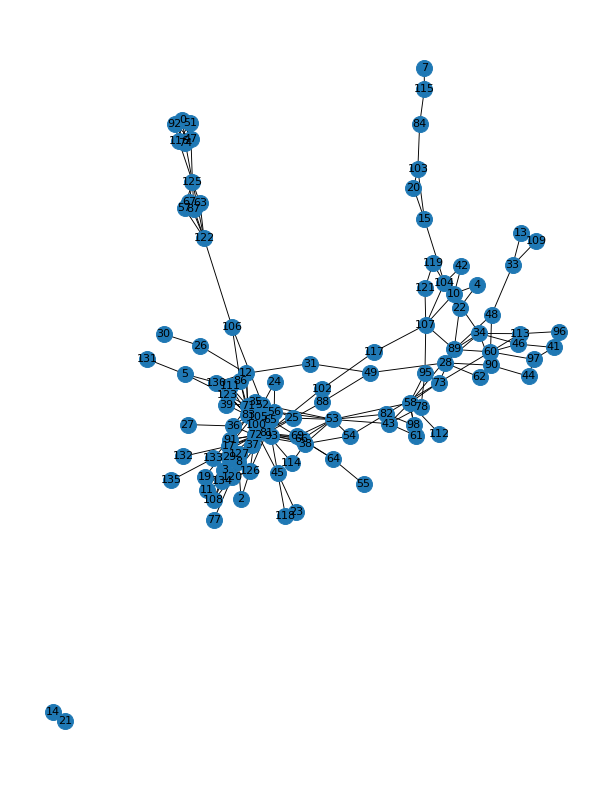

In [87]:
view_graph(g1)

In [47]:
get_connected_nodes(g1)

[{3,
  5,
  8,
  12,
  17,
  19,
  29,
  52,
  71,
  72,
  81,
  83,
  91,
  93,
  100,
  105,
  111,
  120,
  123,
  127,
  130,
  133,
  134},
 {4, 10, 22, 43, 48, 58, 61, 73, 78, 89, 95, 98, 104, 107},
 {7, 115},
 {15, 20, 103},
 {23, 45},
 {33, 109},
 {38, 54, 82},
 {41, 46},
 {47, 51, 57, 63, 74, 87, 92, 116, 122, 125},
 {64, 66, 69},
 {102, 117},
 {119, 121}]

In [48]:
con_coms = split_into_communities(g1, 0, 4)

In [49]:
rg1 = get_community_graph(con_coms)

<IPython.core.display.Javascript object>


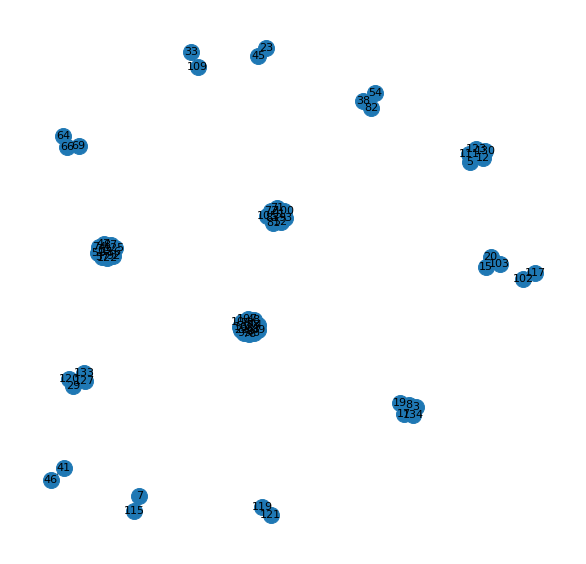

In [50]:
view_graph(rg1)

<IPython.core.display.Javascript object>


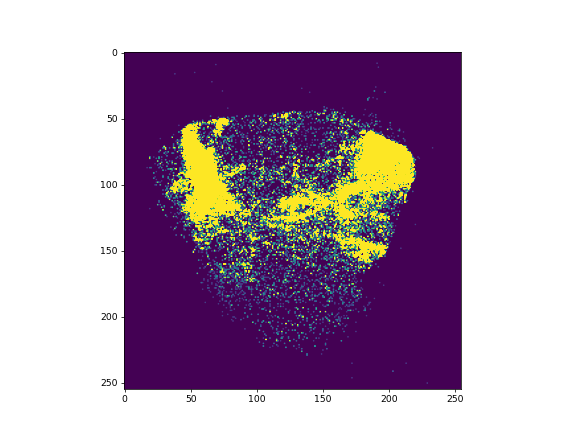

In [51]:
plt.figure()
plt.imshow(all_df[32], vmax = 5)

In [88]:
cc1 = get_connected_nodes(rg1)

ndf1, con_patts1 = get_new_dfs(all_df, cc1, i1,info=True)

<IPython.core.display.Javascript object>


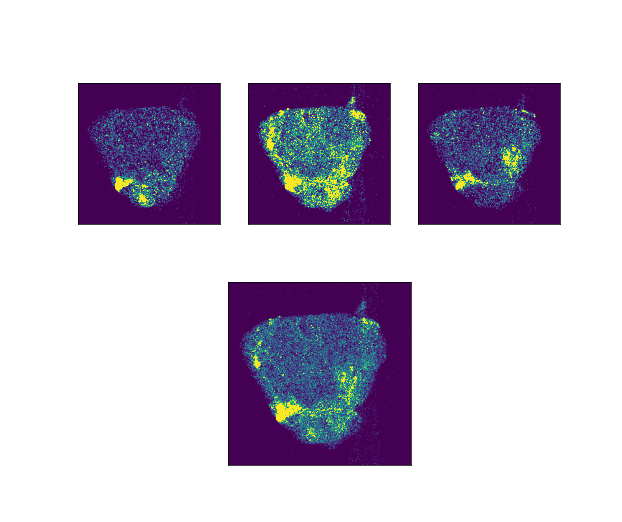

In [92]:
plot_con_patts(con_patts1[4], vmax = 5)

In [59]:
len(ndf1)

85

## Pass 2

In [60]:
d2 = get_distance_matrix(ndf1, nrmse, do_nothing)

In [64]:
ut2 = thresh_distances(d2, 0.95)

In [65]:
g2, i2 = get_graph_from_connectivity(ut2)

<IPython.core.display.Javascript object>


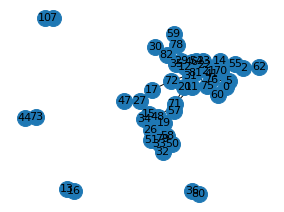

In [66]:
view_graph(g2)

In [67]:
cc2 = get_connected_nodes(g2)
print(cc2)

[{0, 2, 5, 11, 12, 14, 15, 17, 19, 20, 21, 22, 23, 26, 27, 29, 30, 31, 32, 33, 34, 35, 41, 46, 47, 48, 50, 51, 54, 55, 57, 58, 59, 60, 62, 70, 71, 72, 75, 76, 78, 79, 81, 82}, {10, 7}, {16, 13}, {80, 36}, {73, 44}]


In [68]:
con_coms_2 = split_into_communities(g2, 0, 5)

In [69]:
rg2 = get_community_graph(con_coms_2)

<IPython.core.display.Javascript object>


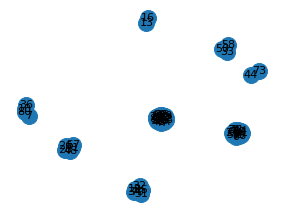

In [70]:
view_graph(rg2)

In [71]:
cc2 = get_connected_nodes(rg2)

In [72]:
ndf2, con_patts2 = get_new_dfs(ndf1, cc2, i2,info=True)

<IPython.core.display.Javascript object>


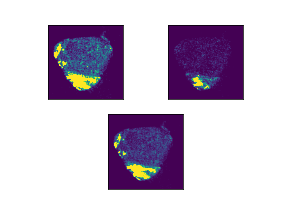

In [73]:
plot_con_patts(con_patts2[3], vmax = 5)

In [74]:
len(ndf2)

42

## Finally need to combine the new dark fields to get clusters

In [75]:
ndf5 = ndf2

##### gaussian process smooths the dfs out for comparisons

ndf5 = gaussian_process(ndf2)

In [76]:
f_df = np.moveaxis(np.asarray(ndf5), 0, -1)

In [77]:
from sklearn.mixture import GaussianMixture as GM

In [78]:
ffdf = f_df.reshape((255*255,len(ndf5)))

In [79]:
c = GM(10).fit_predict(ffdf)

In [80]:
c_df = c.reshape((255,255))

<IPython.core.display.Javascript object>


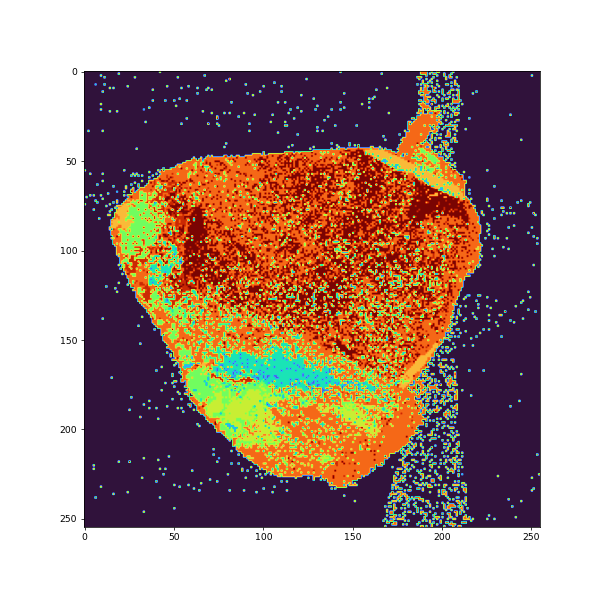

In [81]:
plt.figure()
plt.imshow(c_df, cmap = 'turbo')

In [93]:
np.save('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/ManualSegmentation/df_manual_seg_pres.npy', c_df)